In [1]:
# Install Required Dependencies
# Run this cell first to install all necessary packages

import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError:
        print(f"❌ Failed to install {package}")    

# List of required packages
required_packages = [
    "pandas",
    "numpy", 
    "tensorflow",
    "matplotlib",
    "seaborn",
    "scikit-learn"
]

print("Installing required dependencies...")
print("="*50)

for package in required_packages:
    install_package(package)

print("="*50)
print("All dependencies installation completed!")
print("You can now run the subsequent cells.")


Installing required dependencies...
✅ pandas installed successfully
✅ numpy installed successfully
✅ tensorflow installed successfully
✅ matplotlib installed successfully
✅ seaborn installed successfully
✅ scikit-learn installed successfully
All dependencies installation completed!
You can now run the subsequent cells.


In [2]:
# Waste Management Data Analysis and FLANN Model Training
# Import required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, constraints
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.3


In [3]:
# Load and examine the waste management dataset
df = pd.read_csv('w.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nDataset statistics:")
print(df.describe())


Dataset Info:
Shape: (850, 13)
Columns: ['City/District', 'Waste Type', 'Waste Generated (Tons/Day)', 'Recycling Rate (%)', 'Population Density (People/km²)', 'Municipal Efficiency Score (1-10)', 'Disposal Method', 'Cost of Waste Management (₹/Ton)', 'Awareness Campaigns Count', 'Landfill Name', 'Landfill Location (Lat, Long)', 'Landfill Capacity (Tons)', 'Year']

First 5 rows:
  City/District    Waste Type  Waste Generated (Tons/Day)  Recycling Rate (%)  \
0        Mumbai       Plastic                        6610                  68   
1        Mumbai       Organic                        1181                  56   
2        Mumbai       E-Waste                        8162                  53   
3        Mumbai  Construction                        8929                  56   
4        Mumbai     Hazardous                        5032                  44   

   Population Density (People/km²)  Municipal Efficiency Score (1-10)  \
0                            11191                         

In [4]:
# Data Preprocessing Pipeline
# Following the preprocessing steps as shown in the image:
# 1. Standardization (mean removal and variance scaling)
# 2. Non-linear transformation
# 3. Normalization
# 4. Encoding categorical features
# 5. Imputation of missing values
# Note: Excluding Discretization, Generating polynomial features, and Custom transformers as indicated

print("Starting Data Preprocessing...")

# Create a copy of the dataset for preprocessing
df_processed = df.copy()

# Step 1: Handle missing values first (if any)
print("Step 1: Imputation of missing values")
missing_cols = df_processed.columns[df_processed.isnull().any()].tolist()
if missing_cols:
    print(f"Found missing values in: {missing_cols}")
    for col in missing_cols:
        if df_processed[col].dtype in ['object']:
            # For categorical columns, use most frequent
            imputer = SimpleImputer(strategy='most_frequent')
            df_processed[col] = imputer.fit_transform(df_processed[[col]]).flatten()
        else:
            # For numerical columns, use mean
            imputer = SimpleImputer(strategy='mean')
            df_processed[col] = imputer.fit_transform(df_processed[[col]]).flatten()
    print("Missing values imputed successfully")
else:
    print("No missing values found in the dataset")

# Step 2: Encode categorical features
print("\nStep 2: Encoding categorical features")
categorical_columns = ['City/District', 'Waste Type', 'Disposal Method', 'Landfill Name']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Drop original categorical columns
df_processed = df_processed.drop(columns=categorical_columns)

# Step 3: Handle the Landfill Location column (Lat, Long)
print("\nStep 3: Processing Landfill Location")
# Split the location string into lat and long
location_parts = df_processed['Landfill Location (Lat, Long)'].str.split(', ', expand=True)
df_processed['Latitude'] = location_parts[0].astype(float)
df_processed['Longitude'] = location_parts[1].astype(float)
df_processed = df_processed.drop(columns=['Landfill Location (Lat, Long)'])

print("Preprocessing steps 1-3 completed successfully!")


Starting Data Preprocessing...
Step 1: Imputation of missing values
No missing values found in the dataset

Step 2: Encoding categorical features
Encoded City/District: 34 unique values
Encoded Waste Type: 5 unique values
Encoded Disposal Method: 4 unique values
Encoded Landfill Name: 34 unique values

Step 3: Processing Landfill Location
Preprocessing steps 1-3 completed successfully!


In [5]:
# Continue preprocessing: Standardization, Non-linear transformation, and Normalization

# Step 4: Prepare features for scaling
print("Step 4: Preparing features for scaling")
# Select numerical features for scaling
numerical_features = ['Waste Generated (Tons/Day)', 'Recycling Rate (%)', 
                     'Population Density (People/km²)', 'Municipal Efficiency Score (1-10)',
                     'Cost of Waste Management (₹/Ton)', 'Awareness Campaigns Count', 
                     'Landfill Capacity (Tons)', 'Year', 'Latitude', 'Longitude']

# Add encoded categorical features
encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
all_features = numerical_features + encoded_features

print(f"Features to be processed: {len(all_features)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Encoded categorical features: {len(encoded_features)}")

# Extract feature matrix
X = df_processed[all_features].values
print(f"Feature matrix shape: {X.shape}")

# Step 5: Standardization (Mean removal and variance scaling)
print("\nStep 5: Standardization (Mean removal and variance scaling)")
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X)
print("Standardization completed")

# Step 6: Non-linear transformation (Log transformation for positive values)
print("\nStep 6: Non-linear transformation")
X_transformed = X_standardized.copy()
# Apply log transformation to positive values, keeping negative values as is
positive_mask = X_transformed > 0
X_transformed[positive_mask] = np.log1p(X_transformed[positive_mask])
print("Non-linear transformation (log) completed")

# Step 7: Normalization (Min-Max scaling)
print("\nStep 7: Normalization (Min-Max scaling)")
scaler_minmax = MinMaxScaler()
X_normalized = scaler_minmax.fit_transform(X_transformed)
print("Normalization completed")

print(f"\nFinal processed feature matrix shape: {X_normalized.shape}")
print("All preprocessing steps completed successfully!")


Step 4: Preparing features for scaling
Features to be processed: 14
Numerical features: 10
Encoded categorical features: 4
Feature matrix shape: (850, 14)

Step 5: Standardization (Mean removal and variance scaling)
Standardization completed

Step 6: Non-linear transformation
Non-linear transformation (log) completed

Step 7: Normalization (Min-Max scaling)
Normalization completed

Final processed feature matrix shape: (850, 14)
All preprocessing steps completed successfully!


In [6]:
# Train-Test Split (7:3 ratio)
print("Step 8: Train-Test Split (7:3 ratio)")

# Use the normalized features
X_final = X_normalized

# Perform train-test split with 70% training and 30% testing
X_train, X_test, train_indices, test_indices = train_test_split(
    X_final, np.arange(len(X_final)), test_size=0.3, random_state=42, stratify=None
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

# Optional: If X has more than 2 dimensions, flatten it
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

print("Train-test split completed successfully!")


Step 8: Train-Test Split (7:3 ratio)
Training set size: 595 samples (70.0%)
Test set size: 255 samples (30.0%)
Number of features: 14
Train-test split completed successfully!


In [7]:
# Create 3 Clusters using K-means Clustering
print("Step 9: Creating 3 clusters using K-means clustering")

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train)

print(f"K-means clustering completed with 3 clusters")
print(f"Cluster distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")

# Get cluster centers
cluster_centers = kmeans.cluster_centers_
print(f"Cluster centers shape: {cluster_centers.shape}")

# Predict clusters for test set
test_cluster_labels = kmeans.predict(X_test)
print(f"Test set cluster distribution:")
unique_test, counts_test = np.unique(test_cluster_labels, return_counts=True)
for cluster, count in zip(unique_test, counts_test):
    print(f"  Cluster {cluster}: {count} samples ({count/len(test_cluster_labels)*100:.1f}%)")

print("Clustering completed successfully!")


Step 9: Creating 3 clusters using K-means clustering
K-means clustering completed with 3 clusters
Cluster distribution:
  Cluster 0: 233 samples (39.2%)
  Cluster 1: 219 samples (36.8%)
  Cluster 2: 143 samples (24.0%)
Cluster centers shape: (3, 14)
Test set cluster distribution:
  Cluster 0: 105 samples (41.2%)
  Cluster 1: 98 samples (38.4%)
  Cluster 2: 52 samples (20.4%)
Clustering completed successfully!


In [8]:
# Prepare data for FLANN model training
print("Step 10: Preparing data for FLANN model training")

# Convert cluster labels to categorical format for multi-class classification
y_train = to_categorical(cluster_labels, num_classes=3)
y_test = to_categorical(test_cluster_labels, num_classes=3)

# Create label encoder for cluster classes
label_encoder = LabelEncoder()
label_encoder.fit(['Cluster_0', 'Cluster_1', 'Cluster_2'])

# Get dataset information
num_features = X_train.shape[1]
num_classes = y_train.shape[1]

print("Dataset shapes:")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
print(f"Number of features: {num_features}, Number of classes: {num_classes}")

print("Data preparation for FLANN model completed!")


Step 10: Preparing data for FLANN model training
Dataset shapes:
X_train shape: (595, 14), X_test shape: (255, 14)
y_train shape: (595, 3), y_test shape: (255, 3)
Number of features: 14, Number of classes: 3
Data preparation for FLANN model completed!


In [9]:
# FLANN Model Implementation
print("Step 11: Implementing FLANN (Functional Link Artificial Neural Network) Model")

# ----------------- Custom Layers ----------------- #

class WeightedFeatureLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.w_x = self.add_weight(
            shape=(input_shape[-1],), initializer="ones", trainable=False, name="w_x"
        )
        self.w_sin = self.add_weight(
            shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_sin"
        )
        self.w_cos = self.add_weight(
            shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_cos"
        )

    def call(self, inputs):
        transformed = tf.concat([
            self.w_x * inputs,
            self.w_sin * tf.sin(inputs),
            self.w_cos * tf.cos(inputs)
        ], axis=-1)
        return transformed

# ----------------- Model(FLANN) ----------------- #

def create_ecg_multiclass_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        WeightedFeatureLayer(),
        layers.Dense(num_classes, activation='softmax', trainable=False)  # For multi-class
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',  # Multi-class loss
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Create the FLANN model
model = create_ecg_multiclass_model(num_features, num_classes)
print("FLANN model created successfully!")
print("\nModel Summary:")
model.summary()


Step 11: Implementing FLANN (Functional Link Artificial Neural Network) Model

FLANN model created successfully!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ weighted_feature_layer          │ (None, 42)             │            42 │
│ (WeightedFeatureLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 143 (572.00 B)

In [10]:
# ----------------- Training ----------------- #

print("Step 12: Training the FLANN model")

# Train the model
history = model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)
    ],
    verbose=1
)

print("Model training completed successfully!")


Step 12: Training the FLANN model
Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4013 - loss: 1.0619 - precision: 0.4348 - recall: 0.1891 - val_accuracy: 0.3950 - val_loss: 1.0483 - val_precision: 0.3333 - val_recall: 0.1597
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4790 - loss: 0.9638 - precision: 0.5407 - recall: 0.2374 - val_accuracy: 0.4118 - val_loss: 0.9828 - val_precision: 0.3881 - val_recall: 0.2185
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5357 - loss: 0.9048 - precision: 0.6091 - recall: 0.2815 - val_accuracy: 0.4454 - val_loss: 0.9255 - val_precision: 0.4091 - val_recall: 0.2269
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5819 - loss: 0.8525 - precision: 0.6723 - recall: 0.3361 - val_accuracy: 0.4958 - val_loss: 0.8747 - val_precision: 0.4861 - val_recall: 0.2941
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6282 - loss: 0.8055 - precision: 0.7097 - recall: 0.3697 - v

Step 13: Model Evaluation
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

   Cluster_0       0.93      0.94      0.93       105
   Cluster_1       0.95      0.93      0.94        98
   Cluster_2       0.98      0.98      0.98        52

    accuracy                           0.95       255
   macro avg       0.95      0.95      0.95       255
weighted avg       0.95      0.95      0.95       255


Confusion Matrix:
[[99  5  1]
 [ 7 91  0]
 [ 1  0 51]]

Overall Accuracy: 0.9451 (94.51%)


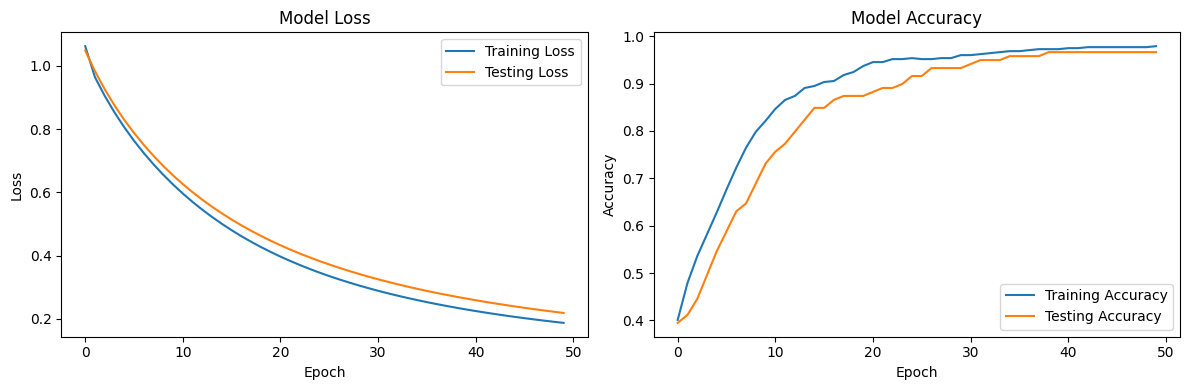

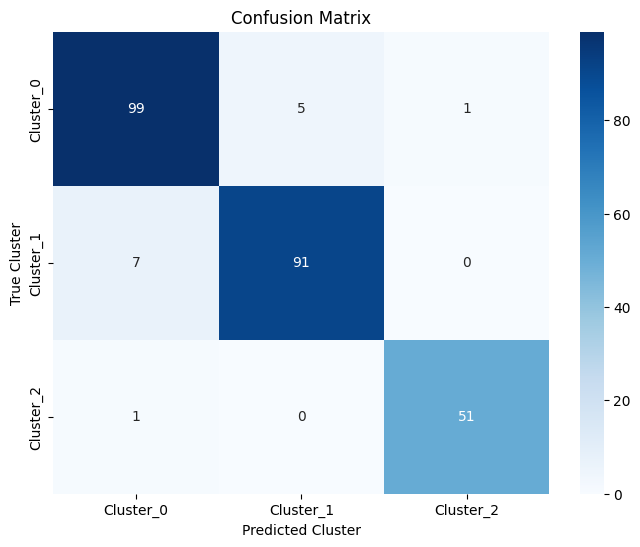

Model evaluation completed successfully!


In [11]:
# ----------------- Evaluation ----------------- #

print("Step 13: Model Evaluation")

# Make predictions on test set
test_preds = model.predict(X_test.astype(np.float32))
predicted_labels = np.argmax(test_preds, axis=1)
true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_.astype(str)))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Calculate and display accuracy
accuracy = np.mean(predicted_labels == true_labels)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.show()

print("Model evaluation completed successfully!")


In [12]:
# FLANN Variants: Polynomial and Chebyshev feature layers and models

from sklearn.metrics import f1_score, roc_auc_score

# ----------------- Custom Layers ----------------- #

class PolynomialFeatureLayer(layers.Layer):
    def __init__(self, degree: int = 3, **kwargs):
        super().__init__(**kwargs)
        self.degree = degree

    def build(self, input_shape):
        # weights per basis component (exclude bias)
        self.w = []
        for d in range(1, self.degree + 1):
            self.w.append(self.add_weight(
                shape=(input_shape[-1],), initializer="ones", trainable=True, name=f"w_x_pow_{d}"
            ))

    def call(self, inputs):
        feats = []
        for d, w_d in enumerate(self.w, start=1):
            feats.append(w_d * tf.pow(inputs, d))
        return tf.concat(feats, axis=-1)


class ChebyshevFeatureLayer(layers.Layer):
    def __init__(self, order: int = 3, **kwargs):
        super().__init__(**kwargs)
        self.order = order

    def build(self, input_shape):
        # weights per Chebyshev component T1..T_order
        self.w = []
        for k in range(1, self.order + 1):
            self.w.append(self.add_weight(
                shape=(input_shape[-1],), initializer="ones", trainable=True, name=f"w_T{k}"
            ))

    def call(self, inputs):
        # Chebyshev T1=x, T2=2x^2-1, T3=4x^3-3x, etc. (first kind)
        x = inputs
        feats = []
        if self.order >= 1:
            feats.append(self.w[0] * x)
        if self.order >= 2:
            T2 = 2.0 * tf.pow(x, 2.0) - 1.0
            feats.append(self.w[1] * T2)
        for k in range(3, self.order + 1):
            # Recurrence: T_k = 2x*T_{k-1} - T_{k-2}
            if k == 3:
                T_km1 = T2
                T_km2 = x
            T_k = 2.0 * x * T_km1 - T_km2
            feats.append(self.w[k - 1] * T_k)
            T_km2, T_km1 = T_km1, T_k
        return tf.concat(feats, axis=-1)


# ----------------- Model Builders ----------------- #

def create_poly_multiclass_model(input_shape: int, num_classes: int, degree: int = 3):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        PolynomialFeatureLayer(degree=degree),
        layers.Dense(num_classes, activation='softmax', trainable=False)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model



def create_cheby_multiclass_model(input_shape: int, num_classes: int, order: int = 3):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        ChebyshevFeatureLayer(order=order),
        layers.Dense(num_classes, activation='softmax', trainable=False)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model


In [13]:
# Train Polynomial and Chebyshev FLANN models

# Build models (reuse num_features, num_classes, X_train, y_train from above)
poly_model = create_poly_multiclass_model(num_features, num_classes, degree=3)
cheby_model = create_cheby_multiclass_model(num_features, num_classes, order=3)

print("Training Polynomial FLANN...")
poly_history = poly_model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)],
    verbose=1
)

print("Training Chebyshev FLANN...")
cheby_history = cheby_model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)],
    verbose=1
)


Training Polynomial FLANN...
Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5588 - loss: 1.0503 - precision: 0.5980 - recall: 0.2563 - val_accuracy: 0.6891 - val_loss: 0.8931 - val_precision: 0.7021 - val_recall: 0.2773
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8277 - loss: 0.7325 - precision: 0.9470 - recall: 0.5252 - val_accuracy: 0.8151 - val_loss: 0.6732 - val_precision: 0.9048 - val_recall: 0.6387
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9013 - loss: 0.5553 - precision: 0.9595 - recall: 0.7458 - val_accuracy: 0.8655 - val_loss: 0.5403 - val_precision: 0.9043 - val_recall: 0.7143
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9349 - loss: 0.4475 - precision: 0.9689 - recall: 0.8508 - val_accuracy: 0.8655 - val_loss: 0.4524 - val_precision: 0.9048 - val_recall: 0.7983
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9454 - loss: 0.3756 - precision: 0.9704 - recall: 0.8950 - val_ac

In [14]:
# Evaluate all three models and compute metrics (Accuracy, Macro F1, Macro AUC)

models = {
    'Trigonometric': model,
    'Polynomial': poly_model,
    'Chebyshev': cheby_model
}

histories = {
    'Trigonometric': history,
    'Polynomial': poly_history,
    'Chebyshev': cheby_history
}

metrics = []

for name, mdl in models.items():
    preds = mdl.predict(X_test.astype(np.float32))
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    acc = np.mean(pred_labels == true_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')

    # Macro AUC (one-vs-rest) using probability outputs
    try:
        auc = roc_auc_score(true_labels, preds, multi_class='ovr', average='macro')
    except Exception:
        auc = np.nan

    metrics.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'AUC': auc})

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
           Model  Accuracy        F1       AUC
0  Trigonometric  0.945098  0.950959  0.996910
1     Polynomial  0.996078  0.996713  0.999765
2      Chebyshev  0.992157  0.991928  0.999535


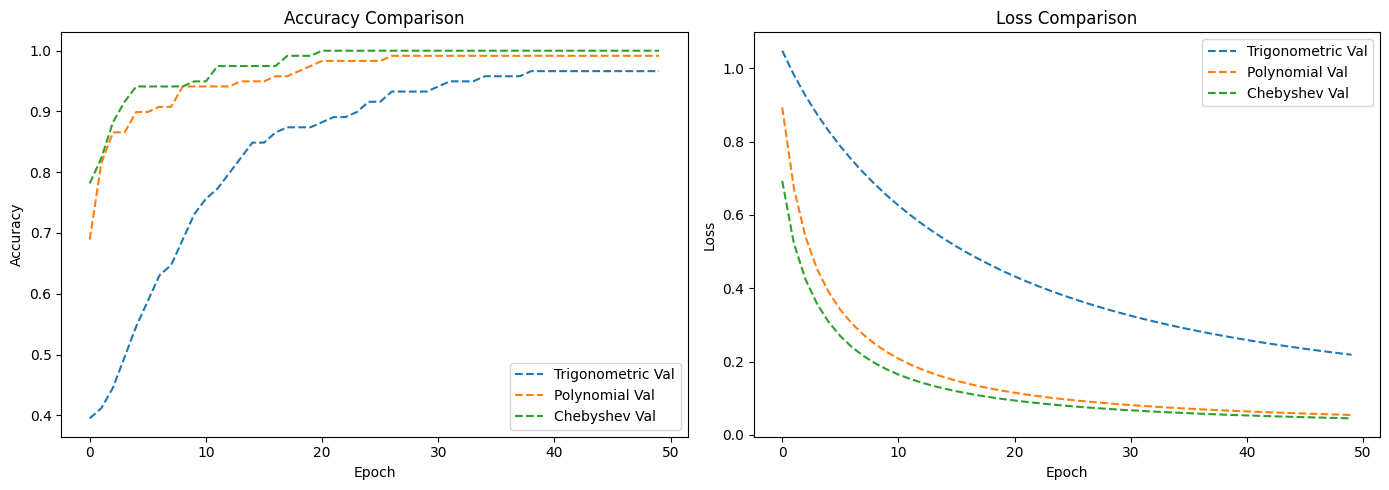

In [ ]:
# Plot comparative accuracy and loss for all three models

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist.history['accuracy'], label=f'{name} Train')
    plt.plot(hist.history['val_accuracy'], label=f'{name} Val', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist.history['loss'], label=f'{name} Train')
    plt.plot(hist.history['val_loss'], label=f'{name} Val', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Build metrics table and run TOPSIS ranking

# Display table
print("\nMetrics Table:")
print(metrics_df)

# TOPSIS: higher is better for all three (Accuracy, F1, AUC)
vals = metrics_df[['Accuracy', 'F1', 'AUC']].values.astype(float)
# Handle NaNs in AUC by replacing with column mean (or zero if all nan)
col_means = np.nanmean(vals, axis=0)
col_means = np.where(np.isnan(col_means), 0.0, col_means)
inds = np.where(np.isnan(vals))
vals[inds] = np.take(col_means, inds[1])

# Normalize
norm = np.linalg.norm(vals, axis=0)
norm = np.where(norm == 0, 1.0, norm)
vals_norm = vals / norm

# Equal weights
weights = np.array([1.0, 1.0, 1.0])
vals_w = vals_norm * weights

# Ideal best/worst (benefit criteria)
ideal_best = np.max(vals_w, axis=0)
ideal_worst = np.min(vals_w, axis=0)

# Distances
D_plus = np.linalg.norm(vals_w - ideal_best, axis=1)
D_minus = np.linalg.norm(vals_w - ideal_worst, axis=1)

# TOPSIS score and rank
scores = D_minus / (D_plus + D_minus + 1e-12)
rank_idx = np.argsort(-scores)

ranked = metrics_df.copy()
ranked['TOPSIS_Score'] = scores
ranked['Rank'] = np.argsort(-scores) + 1
ranked = ranked.sort_values(by='TOPSIS_Score', ascending=False).reset_index(drop=True)

print("\nTOPSIS Ranking:")
print(ranked)



Metrics Table:
           Model  Accuracy        F1       AUC
0  Trigonometric  0.945098  0.950959  0.996910
1     Polynomial  0.996078  0.996713  0.999765
2      Chebyshev  0.992157  0.991928  0.999535

TOPSIS Ranking:
           Model  Accuracy        F1       AUC  TOPSIS_Score  Rank
0     Polynomial  0.996078  0.996713  0.999765      1.000000     3
1      Chebyshev  0.992157  0.991928  0.999535      0.909836     1
2  Trigonometric  0.945098  0.950959  0.996910      0.000000     2


In [20]:
# FLANN Variants with 5-feature expansions (tFLANN, pFLANN, cFLANN)

# Trigonometric 5-branch feature layer: [x, sin(x), cos(x), sin(2x), cos(2x)]
class Trig5FeatureLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.w_x = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=False, name="w_x")
        self.w_sin = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_sin")
        self.w_cos = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_cos")
        self.w_sin2 = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_sin2")
        self.w_cos2 = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True, name="w_cos2")

    def call(self, inputs):
        return tf.concat([
            self.w_x * inputs,
            self.w_sin * tf.sin(inputs),
            self.w_cos * tf.cos(inputs),
            self.w_sin2 * tf.sin(2.0 * inputs),
            self.w_cos2 * tf.cos(2.0 * inputs)
        ], axis=-1)


def create_trig5_multiclass_model(input_shape: int, num_classes: int):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        Trig5FeatureLayer(),
        layers.Dense(num_classes, activation='softmax', trainable=False)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model


# Build 5-expansion models (reuse num_features, num_classes, X_train, y_train)
poly5_model = create_poly_multiclass_model(num_features, num_classes, degree=5)
cheby5_model = create_cheby_multiclass_model(num_features, num_classes, order=5)
trig5_model = create_trig5_multiclass_model(num_features, num_classes)


In [21]:
# Train 5-expansion FLANN models

print("Training 5-expansion Trigonometric FLANN...")
trig5_history = trig5_model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)],
    verbose=1
)

print("Training 5-expansion Polynomial FLANN...")
poly5_history = poly5_model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)],
    verbose=1
)

print("Training 5-expansion Chebyshev FLANN...")
cheby5_history = cheby5_model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)],
    verbose=1
)


Training 5-expansion Trigonometric FLANN...
Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6387 - loss: 0.8703 - precision: 0.7285 - recall: 0.4454 - val_accuracy: 0.7815 - val_loss: 0.6518 - val_precision: 0.8571 - val_recall: 0.6555
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8235 - loss: 0.5655 - precision: 0.8886 - recall: 0.6870 - val_accuracy: 0.8319 - val_loss: 0.5146 - val_precision: 0.8725 - val_recall: 0.7479
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8676 - loss: 0.4543 - precision: 0.9139 - recall: 0.8025 - val_accuracy: 0.8403 - val_loss: 0.4364 - val_precision: 0.8727 - val_recall: 0.8067
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8992 - loss: 0.3858 - precision: 0.9244 - recall: 0.8739 - val_accuracy: 0.8571 - val_loss: 0.3832 - val_precision: 0.8596 - val_recall: 0.8235
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9160 - loss: 0.3376 - precision: 0.9361 - recall: 

In [22]:
# Evaluate 5-expansion models and print metrics + TOPSIS ranking

models_5 = {
    'Trigonometric-5': trig5_model,
    'Polynomial-5': poly5_model,
    'Chebyshev-5': cheby5_model
}

histories_5 = {
    'Trigonometric-5': trig5_history,
    'Polynomial-5': poly5_history,
    'Chebyshev-5': cheby5_history
}

metrics_5 = []
for name, mdl in models_5.items():
    preds = mdl.predict(X_test.astype(np.float32))
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    acc = np.mean(pred_labels == true_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    try:
        auc = roc_auc_score(true_labels, preds, multi_class='ovr', average='macro')
    except Exception:
        auc = np.nan
    metrics_5.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'AUC': auc})

metrics5_df = pd.DataFrame(metrics_5)
print("\nMetrics Table (5-expansion):")
print(metrics5_df)

# TOPSIS ranking for 5-expansion
vals = metrics5_df[['Accuracy', 'F1', 'AUC']].values.astype(float)
col_means = np.nanmean(vals, axis=0)
col_means = np.where(np.isnan(col_means), 0.0, col_means)
inds = np.where(np.isnan(vals))
vals[inds] = np.take(col_means, inds[1])

norm = np.linalg.norm(vals, axis=0)
norm = np.where(norm == 0, 1.0, norm)
vals_norm = vals / norm

weights = np.array([1.0, 1.0, 1.0])
vals_w = vals_norm * weights

ideal_best = np.max(vals_w, axis=0)
ideal_worst = np.min(vals_w, axis=0)

D_plus = np.linalg.norm(vals_w - ideal_best, axis=1)
D_minus = np.linalg.norm(vals_w - ideal_worst, axis=1)

scores = D_minus / (D_plus + D_minus + 1e-12)
metrics5_df['TOPSIS_Score'] = scores
metrics5_df['Rank'] = metrics5_df['TOPSIS_Score'].rank(method='dense').astype(int)

print("\nTOPSIS Ranking (5-expansion):")
print(metrics5_df.sort_values('TOPSIS_Score'))



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Metrics Table (5-expansion):
             Model  Accuracy        F1       AUC
0  Trigonometric-5  0.984314  0.985346  0.999744
1     Polynomial-5  0.996078  0.996713  0.999957
2      Chebyshev-5  0.992157  0.993428  0.999872

TOPSIS Ranking (5-expansion):
             Model  Accuracy        F1       AUC  TOPSIS_Score  Rank
0  Trigonometric-5  0.984314  0.985346  0.999744      0.000000     1
2      Chebyshev-5  0.992157  0.993428  0.999872      0.687597     2
1     Polynomial-5  0.996078  0.996713  0.999957      1.000000     3


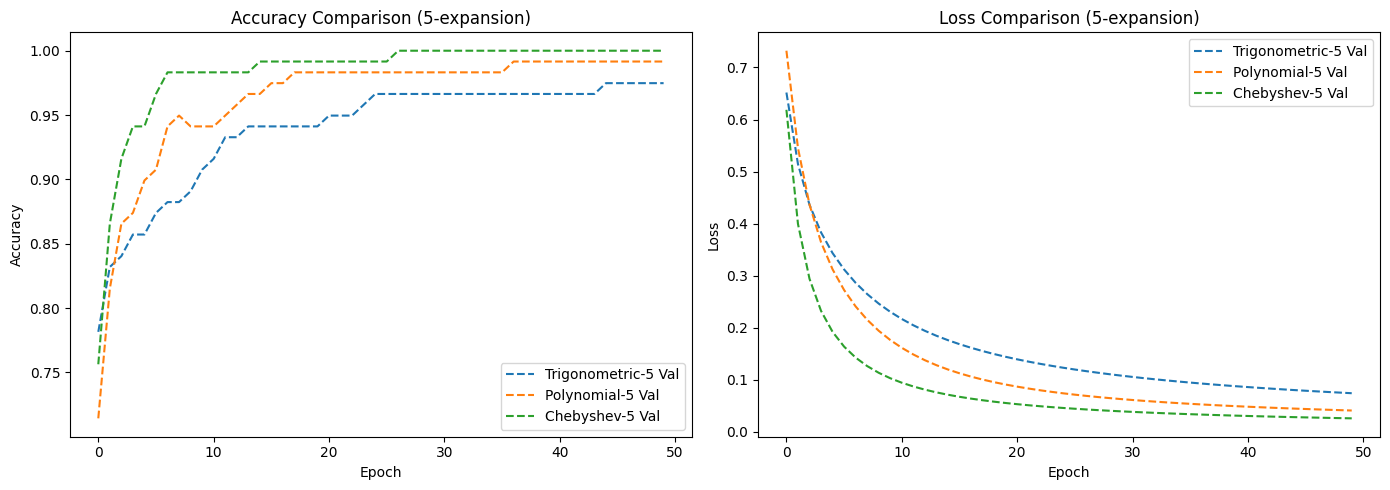

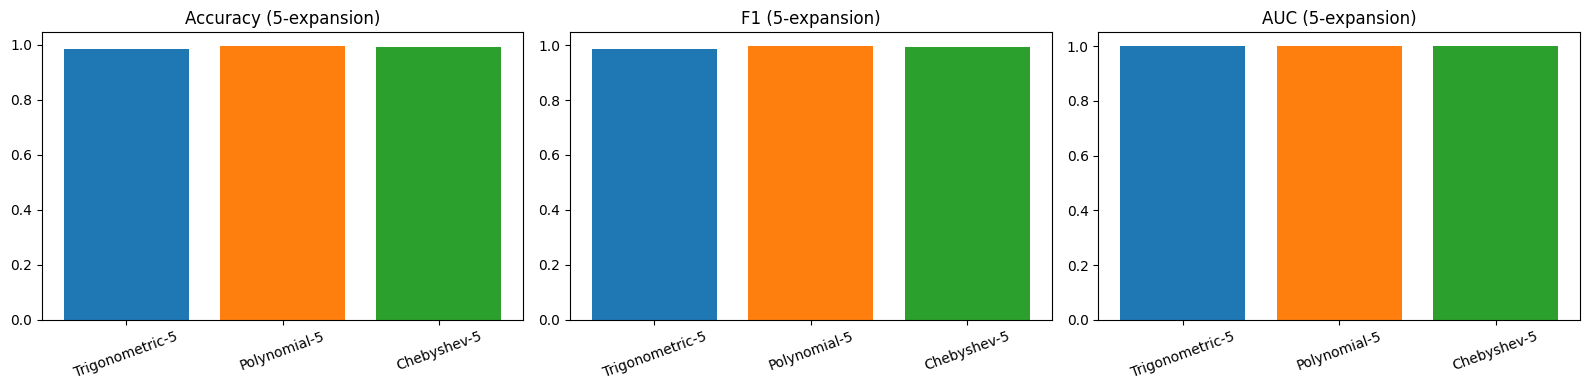

In [25]:
# Plots for 5-expansion models

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name, hist in histories_5.items():
    # plt.plot(hist.history['accuracy'], label=f'{name} Train')
    plt.plot(hist.history['val_accuracy'], label=f'{name} Val', linestyle='--')
plt.title('Accuracy Comparison (5-expansion)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for name, hist in histories_5.items():
    # plt.plot(hist.history['loss'], label=f'{name} Train')
    plt.plot(hist.history['val_loss'], label=f'{name} Val', linestyle='--')
plt.title('Loss Comparison (5-expansion)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Bar charts for Accuracy, F1, AUC
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].bar(metrics5_df['Model'], metrics5_df['Accuracy'], color=['tab:blue','tab:orange','tab:green'])
axes[0].set_title('Accuracy (5-expansion)')
axes[0].set_xticklabels(metrics5_df['Model'], rotation=20)

axes[1].bar(metrics5_df['Model'], metrics5_df['F1'], color=['tab:blue','tab:orange','tab:green'])
axes[1].set_title('F1 (5-expansion)')
axes[1].set_xticklabels(metrics5_df['Model'], rotation=20)

axes[2].bar(metrics5_df['Model'], metrics5_df['AUC'], color=['tab:blue','tab:orange','tab:green'])
axes[2].set_title('AUC (5-expansion)')
axes[2].set_xticklabels(metrics5_df['Model'], rotation=20)

plt.tight_layout()
plt.show()
